# Idea to improve motion network accuracy

Essentially I've done two things I've used a simple CIFAR style network (i.e. small convolution network of the internet that scores over 90% on CIFAR) which gave me 25% accuracy. Then I attempted using VGG16 which is quite a powerful network but I fudged the input layer weights using a trick call network modality. 
In theory this mean fine scale structures are potentially going into further on layers looking like garbage. I still got some decent results. But the training was quite slow. 

I do feel perhaps I'm not being patient with the training. 10 classes is one thing (CIFAR), a 101 is another. And then 1000 classes is definitely something else. Learning more fine grained differences may simply take quite a long time of learnning. I'm considering a much longer amount of training to see how it evolves. 

In [1]:
import os
import sys


up1 = os.path.abspath('../utils/') 
up2 = os.path.abspath('../models/') 
sys.path.insert(0, up1)
sys.path.insert(0, up2)

In [2]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow
from motion_network import getSimonyanOxfordModel
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from keras.optimizers import SGD
import cv2 
import numpy as np



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
from keras.callbacks import ModelCheckpoint, Callback

def get_callbacks(filepath):
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [msave]
file_path = "/data/su_buildup/two_stream_part2/data/weights/motion_model_weights_simonyan_p3.hdf5"
callbacks = get_callbacks(filepath=file_path)

In [4]:
motion_model=getSimonyanOxfordModel((224,224,2), 101, dropout=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 112, 112, 96)      9504      
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 96)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 96)      384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 256)       0         
__________

In [5]:

training_options = { 'rescale' : 1./255, 
                            'shear_range' : 0.2, 
                            'zoom_range' : 0.2, 
                            'horizontal_flip' : True,
                             'rotation_range':20,
                             'width_shift_range':0.2,
                             'height_shift_range':0.2}

validation_options = { 'rescale' : 1./255 }




params_train = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 128,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
           'validation' : False,
               'training_opts' : training_options }

params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 128,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
           'validation' : True,
               'validation_opts' : validation_options}

In [6]:
id_labels_train = get_train_data_opt_flow('../data/ucf101_splits/trainlist01.txt')
labels = id_labels_train[1]
id_test = get_test_data_opt_flow('../data/ucf101_splits/testlist01.txt', \
                       '../data/ucf101_splits/classInd.txt')

training_generator = DataGenerator(*id_labels_train, **params_train)


validation_generator = DataGenerator(id_test[0], id_test[1], **params_valid)

In [7]:
mypotim = SGD(lr=1e-3, momentum=0.9)
motion_model.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [9]:
mod1 = motion_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=10,
                    verbose=1)

Epoch 1/10
74/74 [==============================] - 70s 940ms/step - loss: 4.7630 - acc: 0.0116 - val_loss: 4.7626 - val_acc: 0.0132
Epoch 2/10
74/74 [==============================] - 68s 925ms/step - loss: 4.7633 - acc: 0.0089 - val_loss: 4.7624 - val_acc: 0.0132
Epoch 3/10
74/74 [==============================] - 69s 929ms/step - loss: 4.7621 - acc: 0.0092 - val_loss: 4.7620 - val_acc: 0.0127
Epoch 4/10
74/74 [==============================] - 69s 931ms/step - loss: 4.7623 - acc: 0.0115 - val_loss: 4.7617 - val_acc: 0.0129
Epoch 5/10
74/74 [==============================] - 69s 938ms/step - loss: 4.7619 - acc: 0.0106 - val_loss: 4.7616 - val_acc: 0.0135
Epoch 6/10
74/74 [==============================] - 69s 930ms/step - loss: 4.7621 - acc: 0.0127 - val_loss: 4.7614 - val_acc: 0.0129
Epoch 7/10
74/74 [==============================] - 70s 942ms/step - loss: 4.7615 - acc: 0.0119 - val_loss: 4.7612 - val_acc: 0.0137
Epoch 8/10
 6/74 [=>............................] - ETA: 55s - loss: 

Process ForkPoolWorker-106:
Process ForkPoolWorker-107:
Process ForkPoolWorker-108:
Process ForkPoolWorker-105:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/t

KeyboardInterrupt: 

It seems very interesting that the rate of  improvement is no where  near as fast the keras cifar model and similar. These were up to 5% in validation accuracy compared to 1.5%. But even more interestingly  enough the training accuracy is much lower at about 1% compared to 6% for the former. Perhaps this bodes well for good generalisation of the model 

# Train for a long time 

In [9]:
mod2 = motion_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=30,
                    verbose=1, callbacks=callbacks)

Epoch 1/30
298/298 [==============================] - 64s 216ms/step - loss: 4.7625 - acc: 0.0105 - val_loss: 4.7605 - val_acc: 0.0154
Epoch 2/30
298/298 [==============================] - 68s 228ms/step - loss: 4.7595 - acc: 0.0115 - val_loss: 4.7592 - val_acc: 0.0172
Epoch 3/30
298/298 [==============================] - 64s 215ms/step - loss: 4.7604 - acc: 0.0100 - val_loss: 4.7584 - val_acc: 0.0164
Epoch 4/30
298/298 [==============================] - 64s 215ms/step - loss: 4.7593 - acc: 0.0114 - val_loss: 4.7577 - val_acc: 0.0188
Epoch 5/30
298/298 [==============================] - 64s 216ms/step - loss: 4.7589 - acc: 0.0092 - val_loss: 4.7563 - val_acc: 0.0151
Epoch 6/30
298/298 [==============================] - 66s 222ms/step - loss: 4.7576 - acc: 0.0135 - val_loss: 4.7556 - val_acc: 0.0193
Epoch 7/30
298/298 [==============================] - 65s 216ms/step - loss: 4.7573 - acc: 0.0133 - val_loss: 4.7546 - val_acc: 0.0175
Epoch 8/30
298/298 [==============================] - 6

In [17]:
motion_model2=getSimonyanOxfordModel((224,224,2), 101, dropout=0, printmod=0)
motion_model2.load_weights('/data/su_buildup/two_stream_part2/data/weights/motion_model_weights_simonyan.hdf5')
mypotim = SGD(lr=1e-2, momentum=0.9)
motion_model2.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [18]:
mod3 = motion_model2.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=10,
                    verbose=1, callbacks=callbacks)

Epoch 1/10
149/149 [==============================] - 68s 456ms/step - loss: 4.6527 - acc: 0.0211 - val_loss: 4.6547 - val_acc: 0.0233
Epoch 2/10
149/149 [==============================] - 63s 420ms/step - loss: 4.6408 - acc: 0.0191 - val_loss: 4.6130 - val_acc: 0.0238
Epoch 3/10
149/149 [==============================] - 63s 420ms/step - loss: 4.6224 - acc: 0.0200 - val_loss: 4.6291 - val_acc: 0.0254
Epoch 4/10
149/149 [==============================] - 63s 424ms/step - loss: 4.6075 - acc: 0.0216 - val_loss: 4.6018 - val_acc: 0.0244
Epoch 5/10
149/149 [==============================] - 63s 421ms/step - loss: 4.5980 - acc: 0.0202 - val_loss: 4.5852 - val_acc: 0.0244
Epoch 6/10
149/149 [==============================] - 62s 419ms/step - loss: 4.5895 - acc: 0.0223 - val_loss: 4.5746 - val_acc: 0.0249
Epoch 7/10
149/149 [==============================] - 62s 415ms/step - loss: 4.5847 - acc: 0.0216 - val_loss: 4.5586 - val_acc: 0.0281
Epoch 8/10
149/149 [==============================] - 6

In [19]:
mod2 = motion_model2.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=30,
                    verbose=1, callbacks=callbacks)

Epoch 1/30
149/149 [==============================] - 63s 423ms/step - loss: 4.5457 - acc: 0.0251 - val_loss: 4.5689 - val_acc: 0.0312
Epoch 2/30
149/149 [==============================] - 62s 418ms/step - loss: 4.5406 - acc: 0.0251 - val_loss: 4.5142 - val_acc: 0.0331
Epoch 3/30
149/149 [==============================] - 63s 421ms/step - loss: 4.5198 - acc: 0.0259 - val_loss: 4.4954 - val_acc: 0.0384
Epoch 4/30
149/149 [==============================] - 62s 419ms/step - loss: 4.5180 - acc: 0.0263 - val_loss: 4.4985 - val_acc: 0.0350
Epoch 5/30
149/149 [==============================] - 63s 424ms/step - loss: 4.5065 - acc: 0.0319 - val_loss: 4.4973 - val_acc: 0.0373
Epoch 6/30
149/149 [==============================] - 63s 423ms/step - loss: 4.5042 - acc: 0.0307 - val_loss: 4.4781 - val_acc: 0.0408
Epoch 7/30
149/149 [==============================] - 63s 422ms/step - loss: 4.4944 - acc: 0.0276 - val_loss: 4.4588 - val_acc: 0.0400
Epoch 8/30
149/149 [==============================] - 6

In [27]:
mod2 = motion_model2.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=30,
                    verbose=1, callbacks=callbacks)

Epoch 1/30
149/149 [==============================] - 61s 408ms/step - loss: 4.2799 - acc: 0.0557 - val_loss: 4.2650 - val_acc: 0.0675
Epoch 2/30
149/149 [==============================] - 59s 399ms/step - loss: 4.2622 - acc: 0.0545 - val_loss: 4.2288 - val_acc: 0.0720
Epoch 3/30
149/149 [==============================] - 60s 405ms/step - loss: 4.2599 - acc: 0.0590 - val_loss: 4.2621 - val_acc: 0.0723
Epoch 4/30
149/149 [==============================] - 60s 402ms/step - loss: 4.2498 - acc: 0.0594 - val_loss: 4.2123 - val_acc: 0.0715
Epoch 5/30
149/149 [==============================] - 60s 400ms/step - loss: 4.2380 - acc: 0.0624 - val_loss: 4.2320 - val_acc: 0.0747
Epoch 6/30
149/149 [==============================] - 60s 402ms/step - loss: 4.2548 - acc: 0.0617 - val_loss: 4.1967 - val_acc: 0.0784
Epoch 7/30
149/149 [==============================] - 60s 401ms/step - loss: 4.2156 - acc: 0.0656 - val_loss: 4.2031 - val_acc: 0.0755
Epoch 8/30
149/149 [==============================] - 6

In [ ]:
mod2 = motion_model2.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=220,
                    verbose=1, callbacks=callbacks)

Epoch 1/220
149/149 [==============================] - 62s 419ms/step - loss: 3.9820 - acc: 0.1050 - val_loss: 3.9960 - val_acc: 0.1035
Epoch 2/220
149/149 [==============================] - 63s 421ms/step - loss: 3.9630 - acc: 0.1035 - val_loss: 3.9461 - val_acc: 0.1213
Epoch 3/220
149/149 [==============================] - 67s 447ms/step - loss: 3.9604 - acc: 0.1060 - val_loss: 3.9519 - val_acc: 0.1078
Epoch 4/220
149/149 [==============================] - 65s 437ms/step - loss: 3.9397 - acc: 0.1068 - val_loss: 3.8758 - val_acc: 0.1311
Epoch 5/220
149/149 [==============================] - 65s 438ms/step - loss: 3.9376 - acc: 0.1094 - val_loss: 3.8257 - val_acc: 0.1433
Epoch 6/220
149/149 [==============================] - 67s 448ms/step - loss: 3.9153 - acc: 0.1099 - val_loss: 3.9102 - val_acc: 0.1136
Epoch 7/220
149/149 [==============================] - 69s 460ms/step - loss: 3.9335 - acc: 0.1122 - val_loss: 3.8685 - val_acc: 0.1311
Epoch 8/220
149/149 [===========================

Epoch 61/220
149/149 [==============================] - 84s 567ms/step - loss: 3.5364 - acc: 0.1863 - val_loss: 3.5791 - val_acc: 0.1830
Epoch 62/220
149/149 [==============================] - 89s 597ms/step - loss: 3.5289 - acc: 0.1850 - val_loss: 3.5811 - val_acc: 0.1806
Epoch 63/220
149/149 [==============================] - 86s 574ms/step - loss: 3.5584 - acc: 0.1838 - val_loss: 3.4990 - val_acc: 0.2121
Epoch 64/220
  6/149 [>.............................] - ETA: 1:56 - loss: 3.3704 - acc: 0.2266

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.439771). Check your callbacks.
  % delta_t_median)


  9/149 [>.............................] - ETA: 2:01 - loss: 3.4509 - acc: 0.2083

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.433022). Check your callbacks.
  % delta_t_median)


 11/149 [=>............................] - ETA: 1:54 - loss: 3.4421 - acc: 0.2003

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.326841). Check your callbacks.
  % delta_t_median)


149/149 [==============================] - 87s 581ms/step - loss: 3.5368 - acc: 0.1860 - val_loss: 3.6171 - val_acc: 0.1928
Epoch 65/220
149/149 [==============================] - 70s 473ms/step - loss: 3.5101 - acc: 0.1801 - val_loss: 3.5444 - val_acc: 0.2018
Epoch 66/220
149/149 [==============================] - 85s 571ms/step - loss: 3.4945 - acc: 0.1933 - val_loss: 3.4605 - val_acc: 0.2050
Epoch 67/220
149/149 [==============================] - 82s 552ms/step - loss: 3.5476 - acc: 0.1860 - val_loss: 3.5594 - val_acc: 0.1957
Epoch 68/220
149/149 [==============================] - 79s 532ms/step - loss: 3.5133 - acc: 0.1927 - val_loss: 3.6091 - val_acc: 0.1870
Epoch 69/220
149/149 [==============================] - 87s 581ms/step - loss: 3.5285 - acc: 0.1861 - val_loss: 3.5097 - val_acc: 0.1928
Epoch 70/220
149/149 [==============================] - 86s 575ms/step - loss: 3.5463 - acc: 0.1894 - val_loss: 3.5281 - val_acc: 0.2029
Epoch 71/220
149/149 [==============================] 

In [6]:
motion_model3=getSimonyanOxfordModel((224,224,2), 101, dropout=0, printmod=0)
motion_model3.load_weights('/data/su_buildup/two_stream_part2/data/weights/motion_model_weights_simonyan.hdf5')
mypotim = SGD(lr=1e-3, momentum=0.9)
motion_model3.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [7]:
mod3 = motion_model3.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=10,
                    verbose=1, callbacks=callbacks)

Epoch 1/10
149/149 [==============================] - 187s 1s/step - loss: 3.3665 - acc: 0.2165 - val_loss: 3.3984 - val_acc: 0.2288
Epoch 2/10
149/149 [==============================] - 63s 426ms/step - loss: 3.3277 - acc: 0.2265 - val_loss: 3.3696 - val_acc: 0.2354
Epoch 3/10
149/149 [==============================] - 63s 422ms/step - loss: 3.3125 - acc: 0.2236 - val_loss: 3.3285 - val_acc: 0.2376
Epoch 4/10
149/149 [==============================] - 63s 424ms/step - loss: 3.2604 - acc: 0.2397 - val_loss: 3.3203 - val_acc: 0.2476
Epoch 5/10
149/149 [==============================] - 63s 423ms/step - loss: 3.2704 - acc: 0.2373 - val_loss: 3.3142 - val_acc: 0.2474
Epoch 6/10
149/149 [==============================] - 63s 422ms/step - loss: 3.2357 - acc: 0.2354 - val_loss: 3.3243 - val_acc: 0.2484
Epoch 7/10
149/149 [==============================] - 62s 419ms/step - loss: 3.2193 - acc: 0.2432 - val_loss: 3.2985 - val_acc: 0.2474
Epoch 8/10
149/149 [==============================] - 63s

In [8]:
mod3 = motion_model3.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=30,
                    verbose=1, callbacks=callbacks)

Epoch 1/30
149/149 [==============================] - 63s 421ms/step - loss: 3.1963 - acc: 0.2481 - val_loss: 3.2625 - val_acc: 0.2577
Epoch 2/30
149/149 [==============================] - 62s 419ms/step - loss: 3.1773 - acc: 0.2497 - val_loss: 3.2483 - val_acc: 0.2579
Epoch 3/30
149/149 [==============================] - 62s 416ms/step - loss: 3.1576 - acc: 0.2607 - val_loss: 3.2511 - val_acc: 0.2519
Epoch 4/30
149/149 [==============================] - 63s 421ms/step - loss: 3.1708 - acc: 0.2570 - val_loss: 3.2391 - val_acc: 0.2627
Epoch 5/30
149/149 [==============================] - 63s 423ms/step - loss: 3.1426 - acc: 0.2518 - val_loss: 3.2347 - val_acc: 0.2521
Epoch 6/30
149/149 [==============================] - 63s 421ms/step - loss: 3.1199 - acc: 0.2573 - val_loss: 3.2530 - val_acc: 0.2598
Epoch 7/30
149/149 [==============================] - 62s 419ms/step - loss: 3.1447 - acc: 0.2544 - val_loss: 3.2246 - val_acc: 0.2577
Epoch 8/30
149/149 [==============================] - 6

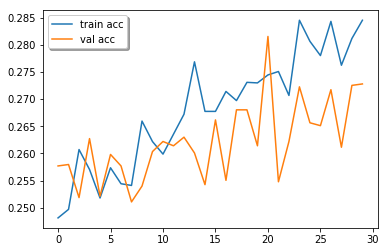

In [9]:

fig, ax = plt.subplots()
ax.plot(mod3.history['acc'], label='train acc')
ax.plot(mod3.history['val_acc'], label='val acc')
legend = ax.legend(loc='best', shadow=True)

In [6]:
motion_model4=getSimonyanOxfordModel((224,224,2), 101, dropout=0, printmod=0)
motion_model4.load_weights('/data/su_buildup/two_stream_part2/data/weights/motion_model_weights_simonyan_p2.hdf5')
mypotim = SGD(lr=1e-3)
motion_model4.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [7]:
mod4 = motion_model4.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=20,
                    verbose=1, callbacks=callbacks)

Epoch 1/20
149/149 [==============================] - 64s 430ms/step - loss: 3.0010 - acc: 0.2868 - val_loss: 3.1577 - val_acc: 0.2643
Epoch 2/20
149/149 [==============================] - 59s 396ms/step - loss: 2.9847 - acc: 0.2903 - val_loss: 3.1353 - val_acc: 0.2728
Epoch 3/20
149/149 [==============================] - 62s 415ms/step - loss: 2.9956 - acc: 0.2843 - val_loss: 3.1009 - val_acc: 0.2865
Epoch 4/20
 30/149 [=====>........................] - ETA: 39s - loss: 2.9910 - acc: 0.2812

Process ForkPoolWorker-31:
Process ForkPoolWorker-29:
Process ForkPoolWorker-30:
Traceback (most recent call last):
Process ForkPoolWorker-32:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tenso

KeyboardInterrupt: 

In [8]:
motion_model4.evaluate_generator(validation_generator)

[3.1448761285361595, 0.2714512711864407]

In [11]:
motion_model5=getSimonyanOxfordModel((224,224,2), 101, dropout=0, printmod=0)
motion_model5.load_weights('/data/su_buildup/two_stream_part2/data/weights/motion_model_weights_simonyan_p2.hdf5')
mypotim = SGD(lr=1e-4, momentum=0.9)
motion_model5.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

ResourceExhaustedError: OOM when allocating tensor with shape[4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: dense_1/bias/Assign = Assign[T=DT_FLOAT, _class=["loc:@dense_1/bias"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_1/bias, dense_1/Const)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'dense_1/bias/Assign', defined at:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-4a16d0f354ef>", line 1, in <module>
    motion_model=getSimonyanOxfordModel((224,224,2), 101, dropout=0)
  File "/data/su_buildup/two_stream_part2/models/motion_network.py", line 203, in getSimonyanOxfordModel
    model.add(Dense(4096))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py", line 492, in add
    output_tensor = layer(self.outputs[0])
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/topology.py", line 592, in __call__
    self.build(input_shapes[0])
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/layers/core.py", line 848, in build
    constraint=self.bias_constraint)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/topology.py", line 416, in add_weight
    constraint=constraint)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 395, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 235, in __init__
    constraint=constraint)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 381, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 281, in assign
    validate_shape=validate_shape)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 61, in assign
    use_locking=use_locking, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: dense_1/bias/Assign = Assign[T=DT_FLOAT, _class=["loc:@dense_1/bias"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_1/bias, dense_1/Const)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
mod4 = motion_model5.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=2,
                    verbose=1, callbacks=callbacks)

In [14]:
mypotim = SGD(lr=1e-4)
motion_model5.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [15]:
mod4 = motion_model5.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=10,
                    verbose=1, callbacks=callbacks)

Epoch 1/10
149/149 [==============================] - 63s 420ms/step - loss: 3.0101 - acc: 0.2808 - val_loss: 3.1204 - val_acc: 0.2749
Epoch 2/10
149/149 [==============================] - 61s 408ms/step - loss: 3.0016 - acc: 0.2784 - val_loss: 3.1446 - val_acc: 0.2797
Epoch 3/10
149/149 [==============================] - 61s 407ms/step - loss: 3.0123 - acc: 0.2808 - val_loss: 3.1366 - val_acc: 0.2701
Epoch 4/10
149/149 [==============================] - 60s 405ms/step - loss: 3.0184 - acc: 0.2762 - val_loss: 3.1437 - val_acc: 0.2767
Epoch 5/10
149/149 [==============================] - 60s 403ms/step - loss: 3.0241 - acc: 0.2833 - val_loss: 3.1576 - val_acc: 0.2701
Epoch 6/10
149/149 [==============================] - 60s 403ms/step - loss: 2.9959 - acc: 0.2865 - val_loss: 3.1068 - val_acc: 0.2738
Epoch 7/10
149/149 [==============================] - 60s 405ms/step - loss: 3.0204 - acc: 0.2855 - val_loss: 3.1295 - val_acc: 0.2738
Epoch 8/10
149/149 [==============================] - 6

In [8]:

training_options = { 'rescale' : 1./255, 
                            'shear_range' : 0.2, 
                            'zoom_range' : 0.2, 
                            'horizontal_flip' : True,
                             'rotation_range':20,
                             'width_shift_range':0.2,
                             'height_shift_range':0.2}

validation_options = { 'rescale' : 1./255 }




params_train = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 128,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
           'validation' : False,
               'training_opts' : training_options }

params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 128,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
           'validation' : True,
               'validation_opts' : validation_options}

In [9]:
id_labels_train = get_train_data_opt_flow('../data/ucf101_splits/trainlist01.txt')
labels = id_labels_train[1]
id_test = get_test_data_opt_flow('../data/ucf101_splits/testlist01.txt', \
                       '../data/ucf101_splits/classInd.txt')

training_generator = DataGenerator(*id_labels_train, **params_train)


validation_generator = DataGenerator(id_test[0], id_test[1], **params_valid)

In [10]:
mod4 = motion_model5.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=10,
                    verbose=1, callbacks=callbacks)

NameError: name 'motion_model5' is not defined